In [103]:
%matplotlib inline

# Solar Data Processing with Python Part II

Now we have a grasp of the basics of python, but the whole reason for downloading python in the first place was to analyze solar data. Let's take a closer look at examples of solar data analysis. 

We will be using SunPy to access solar data. SunPy is a python package designed to interface between the powerful tools that exist in other Python Libraries with current repositories of solar data. With SunPy we will show how to: download solar data sets from the VSO, calibrate to industry standards, plot and overlay a time series. 

# Fitting A Gaussian to a Spectral Line


One of the most common data types in solar data processing is a time series. A time series is a measurement of how one physical parameter changes as a function of time. This example shows how to fit a gaussian to a spectral line. In this example, it will be as "real world" as possible.

First, let's import some useful libraries. 

In [110]:
from datetime import datetime, timedelta #we saw these in the last tutorial

import numpy as np 
from astropy.io import fits #how to read .fits files
from astropy.modeling import models, fitting #some handy fitting tools from astropy
import matplotlib.pyplot as plt 
from scipy.integrate import trapz #numerical itegration tool
import astropy.units as u #units!!

Next we need to load in the data set we want to work with:

In [111]:
filename = '/Users/mskirk/Documents/Conferences/SDO 2016/EVS_L2_2011045_01_005_01.fits'

In [112]:
hdulist = fits.open(filename)

So what did we get when we opened the file? Let's take a look:

In [113]:
len(hdulist)

4

We got 4 items in the list. Lets take a look at the first one: 

In [114]:
hdulist[0].header

SIMPLE  =                    T /Dummy Created by MWRFITS v1.11                  
BITPIX  =                    8 /Dummy primary header created by MWRFITS         
NAXIS   =                    0 /No data is associated with this header          
EXTEND  =                    T /Extensions may (will!) be present               

This doesn't contain any useful information. Let's take a look at the second item:

In [115]:
hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                    8 /Number of bytes per row                         
NAXIS2  =                 5200 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                    2 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
EXTNAME = 'SpectrumMeta'                                                        
TUNIT1  = 'nm'              

Alright, now we are getting somewhere. This has wavelength information in units of 'nm' and accuracy information without units. Let's take a look at the other elements of the list we got:

In [116]:
hdulist[2].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  786 /Number of bytes per row                         
NAXIS2  =                    1 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   10 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
EXTNAME = 'SpectrumUnits'                                                       
COMMENT                     

In [117]:
hdulist[3].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                67630 /Number of bytes per row                         
NAXIS2  =                  360 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   10 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
ORIGIN  = '            SDO/EVE SPOC' // LASP, University of Colorado, Boulder   
DATE    = '2014-12-03T15:32:

So it looks like we are working with some wavelength data, spectral information, irradiance data, etc. 

# Plotting Spectral Data
Let's take a look at some of the data we've got. 

In [118]:
len(hdulist[1].data)

5200

In [119]:
hdulist[1].data["WAVELENGTH"]

array([   3.00999999,    3.02999997,    3.04999995, ...,  106.94999695,
        106.97000122,  106.98999786], dtype=float32)

In [120]:
len(hdulist[3].data)

360

In [121]:
hdulist[3].data[0]["IRRADIANCE"]

array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)

(5, 40)

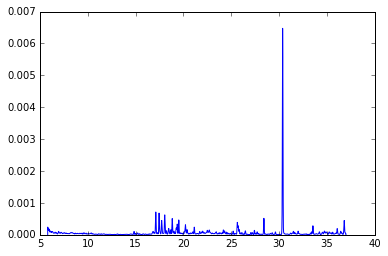

In [122]:
plt.plot(hdulist[1].data["WAVELENGTH"], hdulist[3].data[0]["IRRADIANCE"])
plt.ylim(0, 0.007)
plt.xlim(5, 40)

So now we have a plot of wavelength vs. irradiance. We can see there is one major spike in the data. Let's filter the data so that we just have that one spike. 

In [123]:
w = np.logical_and(hdulist[1].data["WAVELENGTH"] > 30.2, hdulist[1].data["WAVELENGTH"] < 30.6)

In [124]:
w

array([False, False, False, ..., False, False, False], dtype=bool)

This function, "np.logical_and", is similar to a "where" statement in IDL. We can see that "w" is now an array of true and false values. To take a subsection of our data where our filter is true:

In [125]:
wavelength = hdulist[1].data["WAVELENGTH"][w]

In [126]:
wavelength

array([ 30.20999908,  30.22999954,  30.25      ,  30.27000046,
        30.29000092,  30.30999947,  30.32999992,  30.35000038,
        30.37000084,  30.38999939,  30.40999985,  30.43000031,
        30.45000076,  30.46999931,  30.48999977,  30.51000023,
        30.53000069,  30.54999924,  30.56999969,  30.59000015], dtype=float32)

Now, we need to add some units to this data. The header of the file tells us what the units are:

In [127]:
wavelength = u.Quantity(wavelength, unit="nm")

Let's do the same thing to the irradiance data. 

In [128]:
irr = hdulist[3].data[0]["IRRADIANCE"][w]

In [129]:
irr = u.Quantity(irr, unit="W/m**2")

What have we got? Let's plot it and take a look:

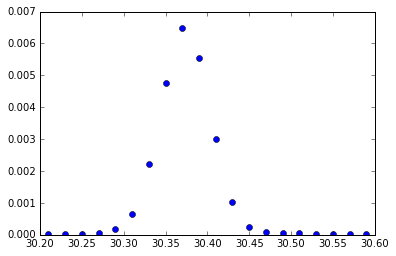

In [130]:
plt.plot(wavelength, irr, 'o')

# Fit He II 304 line with a Gaussian

Now that we have extracted the He II line from our total spectrum, we want to fit it with a gaussian. Do do this we will make use of a couple of packages in in astropy. We will initialize the gaussian fit with some approximations (max, center, FWHM): 

In [131]:
g_init = models.Gaussian1D(0.007, 30.4, .2)

Now let's define a fitting method and produce a fit:

In [132]:
fit_g = fitting.LevMarLSQFitter()

In [133]:
g = fit_g(g_init, wavelength, irr)

Let's take a look at some of the qualities of our fitted gaussian:

In [134]:
g.mean

Parameter('mean', value=30.3733491452)

In [135]:
g.stddev

Parameter('stddev', value=0.029547785343)

In [136]:
g.amplitude

Parameter('amplitude', value=0.00651223358276)

In [137]:
g

<Gaussian1D(amplitude=0.006512233582758824, mean=30.373349145178118, stddev=0.029547785343013666)>

Our guesses wern't too bad, but we over estimated the Standard Deviation by about a factor of 10. The variable 'g' has the fitted parameters of our gaussian but it doesn't actually contain an array. To plot it over the data, we need to create an array of values. We will make an array from 30.2 to 30.6 with 1000 points in it. 

In [138]:
x = np.linspace(30.2, 30.6, 1000)

To find the values of our fit at each location, it is easy:

In [139]:
y = g(x)

Now we can plot it:

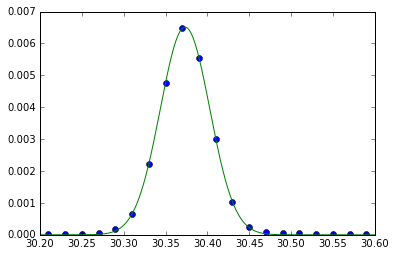

In [140]:
plt.plot(wavelength, irr, 'o')
plt.plot(x, y)

# Ingegrating under the curve. 

Let's find the area under the curve we just created. We can numerically integrate it easily:

In [141]:
intensity = trapz(y,x)

In [142]:
intensity

0.00048233062533621857

# Produce a Light Curve of He II 304 From All Spectra in File

The file we downloaded is a hyper-spectrum. This means that the spectrum changes over time. Can we find how the intensity of the line changes over time using the same fitting tools that we just showcased? Sure, we just need to put everything into a loop. 

In [143]:
x = np.linspace(30.2, 30.6, 1000) #define our wavelength array
intensity = [] # initialize the intensity array
w = np.logical_and(hdulist[1].data["WAVELENGTH"] > 30.2, hdulist[1].data["WAVELENGTH"] < 30.6) # isolate the 304 line
wavelength = hdulist[1].data["WAVELENGTH"][w] # filter all of the spectra
fit_g = fitting.LevMarLSQFitter() #fitting algorithm

for spectrum in hdulist[3].data: #looping over all the spectra (360)
    irr = spectrum["IRRADIANCE"][w] #pulling out the irradiance 
    g_init = models.Gaussian1D(0.007, 30.4, .2) #initialize the gaussian fit
    g = fit_g(g_init, wavelength, irr) #do the fitting 
    y = g(x) # create the curve
    intensity.append(trapz(y,x)) # aggregate the results
intensity = u.Quantity(intensity, unit="nm") # adding units. 

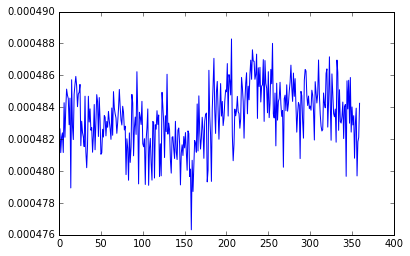

In [144]:
plt.plot(intensity)